# 重み

In [39]:
weights = [
    [6, 7, 15, "NA"],
    [3, 8, 5, 6],
    [12, "NA", 9, 10],
    [4, 11, 9, 11]
]

# 可視化

In [169]:
import networkx as nx
import matplotlib.pyplot as plt

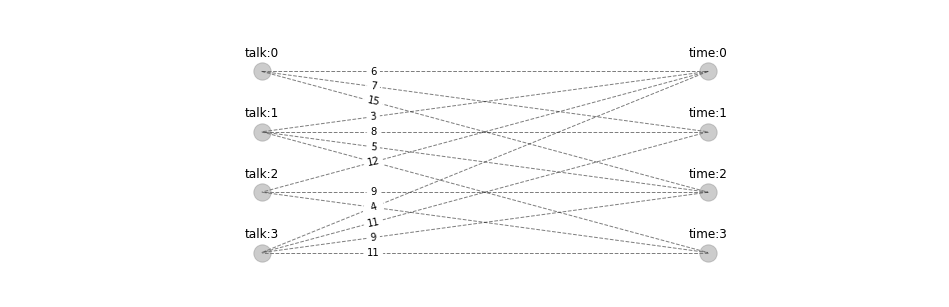

In [184]:
g = nx.Graph()

edge_labels = {}
for talk_idx in range(len(weights)):
    for schedule_idx in range(len(weights[0])):
        weight = weights[talk_idx][schedule_idx]
        if weight == "NA":
            continue
        g.add_edge(f'talk:{talk_idx}', f'time:{schedule_idx}')
        edge_labels[(f'talk:{talk_idx}', f'time:{schedule_idx}')] = weight
        
pos = {}
for i, n in enumerate(g.nodes()):
    side, idx = n.split(":")
    x = 0 if side == 'talk' else 1
    pos[n] = (x, 3 - int(idx))
    
pos_labels = {}
labels = {}
for k, v in pos.items():
    pos_labels[k] = (v[0], v[1]+.3)
    labels[k]= k
    
plt.figure(3, figsize=(16, 5))

nx.draw_networkx_nodes(g, pos, with_labels=False, node_color="gray", alpha=0.4, width=3)
nx.draw_networkx_labels(g, pos_labels, labels)

nx.draw_networkx_edges(g, pos, style='dashed', alpha=.5, width=1)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, label_pos=.75, font_color='black')

plt.axis('off')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 4)
plt.show() 

# Google OR Tools

In [88]:
from ortools.graph import pywrapgraph

def solve_by_ortools(weights):
    # 最小化問題として解くために最大値から値を引いたものにする
    max_weight = max([max([v for v in row if v != "NA"]) for row in weights])
    weights = [[max_weight - v if v != "NA" else "NA" for v in row ] for row in weights]

    assignment = pywrapgraph.LinearSumAssignment()

    for speaker_idx in range(len(weights)):
        for schedule_idx in range(len(weights[0])):
            weight = weights[speaker_idx][schedule_idx]
            if weight != "NA":
                assignment.AddArcWithCost(speaker_idx, schedule_idx, weight)

    # solve_statusで問題が解けたか判定する
    solve_status = assignment.Solve()
    if solve_status == assignment.OPTIMAL:
        total_weight = len(weights) * max_weight - assignment.OptimalCost()
        assign_weights = {}
        for left in range(0, assignment.NumNodes()):
            right = assignment.RightMate(left)
            assign_weights[(left, right)] = max_weight - assignment.AssignmentCost(left)
        return total_weight, assign_weights
    elif solve_status == assignment.INFEASIBLE:
        raise Exception("No assignment is possible.")
    else:
        raise Exception("Other exception.")

In [95]:
total_weight, assign_weights = solve_by_ortools(weights)
print("合計重み:", total_weight)
print("割当:", assign_weights)

合計重み: 46
割当: {(0, 2): 15, (1, 1): 8, (2, 0): 12, (3, 3): 11}


# pulp

In [92]:
from pulp import LpProblem, LpMaximize, LpVariable, LpInteger, LpStatus, lpSum, value

def solve_by_pulp(weights):
    from_nodes =  [u for u in range(len(weights))]
    to_nodes =  [v for v in range(len(weights[0]))]

    prob = LpProblem("", LpMaximize)
    choices = LpVariable.dicts("e", (from_nodes, to_nodes), 0, 1, LpInteger)

    objective = []
    for u in from_nodes:
        for v in to_nodes:
            if weights[u][v] != "NA":
                objective.append(weights[u][v] * choices[u][v])

    prob += lpSum(objective), ""

    for u in from_nodes:
        prob += lpSum([choices[u][v] for v in to_nodes]) <= 1

    for v in to_nodes:
        prob += lpSum([choices[u][v] for u in from_nodes]) <= 1

    prob.solve()
    
    solve_status = LpStatus[prob.status]
    if solve_status == "Optimal":
        total_weight = value(prob.objective)
        assign_weights = {}
        for var in prob.variables():
            if var.varValue:
                _, u, v = var.name.split("_")
                u, v = int(u), int(v)
                assign_weights[(u, v)] = weights[u][v]    

        return total_weight, assign_weights
    elif solve_status == "Infeasible":
        raise Exception("No assignment is possible.")
    else:
        raise Exception("Other exception.")

In [96]:
total_weight, assign_weights = solve_by_pulp(weights)
print("合計重み:", total_weight)
print("割当:", assign_weights)

合計重み: 46.0
割当: {(0, 2): 15, (1, 1): 8, (2, 0): 12, (3, 3): 11}


# munkres

In [90]:
import sys
from munkres import Munkres, make_cost_matrix, DISALLOWED

def solve_by_munkres(weights):
    # munkresで解くためのデータ形式に変換
    # 同時に最小化問題として解くための処理も行う
    cost_matrix = make_cost_matrix(weights, lambda weight: (sys.maxsize - weight) if weight != "NA" else DISALLOWED)
    m = Munkres()
    indexes = m.compute(cost_matrix)
    total_weight = sum(weights[u][v] for u, v in indexes)
    assign_weights = {(u, v): weights[u][v] for u, v in indexes}
    
    return total_weight, assign_weights

In [94]:
total_weight, assign_weights = solve_by_munkres(weights)
print("合計重み:", total_weight)
print("割当:", assign_weights)

合計重み: 46
割当: {(0, 2): 15, (1, 1): 8, (2, 0): 12, (3, 3): 11}


# 可視化

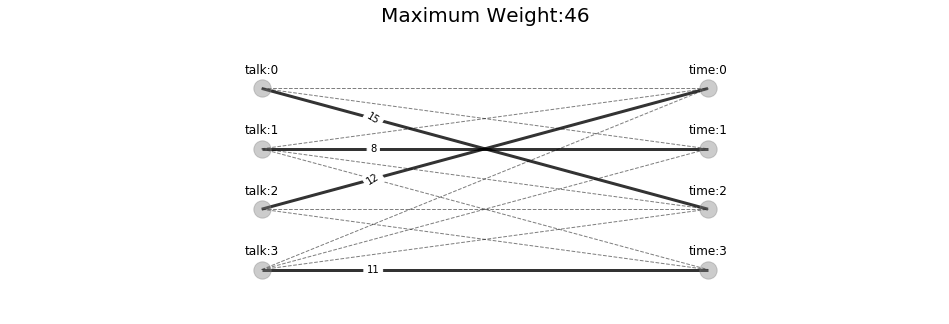

In [199]:
g = nx.Graph()

edge_assigned = []
edge_not_assigned = []
edge_labels = {}

for talk_idx in range(len(weights)):
    for schedule_idx in range(len(weights[0])):
        weight = weights[talk_idx][schedule_idx]
        if weight == "NA":
            continue
        g.add_edge(f'talk:{talk_idx}', f'time:{schedule_idx}')

        is_assigned = assign_weights.get((talk_idx, schedule_idx))

        if is_assigned:
            edge_assigned.append((f'talk:{talk_idx}', f'time:{schedule_idx}'))
            edge_labels[(f'talk:{talk_idx}', f'time:{schedule_idx}')] = weight
        else:
            edge_not_assigned.append((f'talk:{talk_idx}', f'time:{schedule_idx}'))
            edge_labels[(f'talk:{talk_idx}', f'time:{schedule_idx}')] = ""
        
pos = {}
for i, n in enumerate(g.nodes()):
    side, idx = n.split(":")
    x = 0 if side == 'talk' else 1
    pos[n] = (x, 3 - int(idx))
    
pos_labels = {}
labels = {}
for k, v in pos.items():
    pos_labels[k] = (v[0], v[1]+.3)
    labels[k]= k
    
plt.figure(3, figsize=(16, 5))

nx.draw_networkx_edges(g, pos, edgelist=edge_assigned, alpha=.8, width=3)
nx.draw_networkx_edges(g, pos, edgelist=edge_not_assigned, style='dashed', alpha=.5, width=1)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, label_pos=.75, font_color='black')


nx.draw_networkx_nodes(g, pos, with_labels=False, node_color="gray", alpha=0.4, width=3)
nx.draw_networkx_labels(g, pos_labels, labels)

plt.axis('off')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 4)
plt.title(f"Maximum Weight:{int(total_weight)}", fontsize=20)
plt.show() 